<a href="https://colab.research.google.com/github/hal-29/SHAP/blob/main/Shap_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import shap

In [ ]:
# Data Preparation
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

top_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                'mean concavity', 'worst radius', 'worst perimeter',
                'worst area', 'worst concavity']
X = X[top_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
# Model Training and Evaluation
lr_model = LogisticRegression(random_state=42, max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

lr_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)

print("--- Model Performance ---")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_model.predict(X_test_scaled)):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_model.predict(X_test)):.4f}\n")

Logistic Regression Accuracy: 0.9737
Random Forest Accuracy: 0.9737



In [ ]:
# SHAP Analysis
# Logistic Regression
explainer_lr = shap.LinearExplainer(lr_model, X_train_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)

# Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_explanation_rf = explainer_rf(X_test)

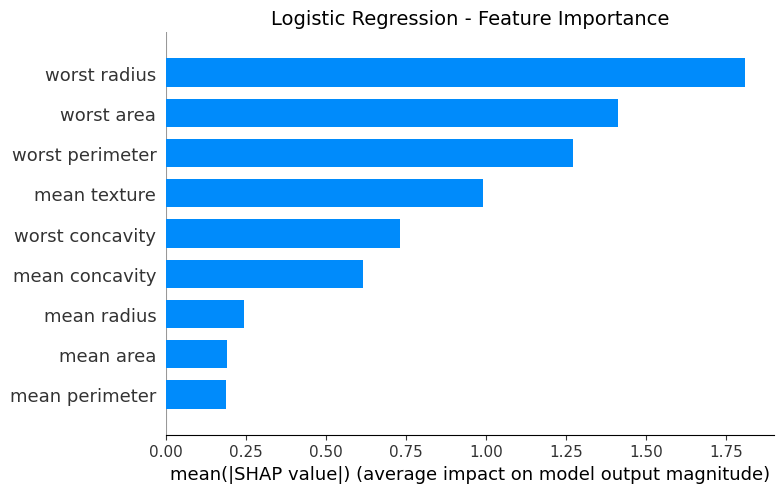

In [ ]:
# Global Feature Importance Comparison

# Bar Plots
shap.summary_plot(shap_values_lr, X_test_scaled_df, plot_type="bar", show=False)
plt.title("Logistic Regression - Feature Importance")
plt.tight_layout()
plt.show()

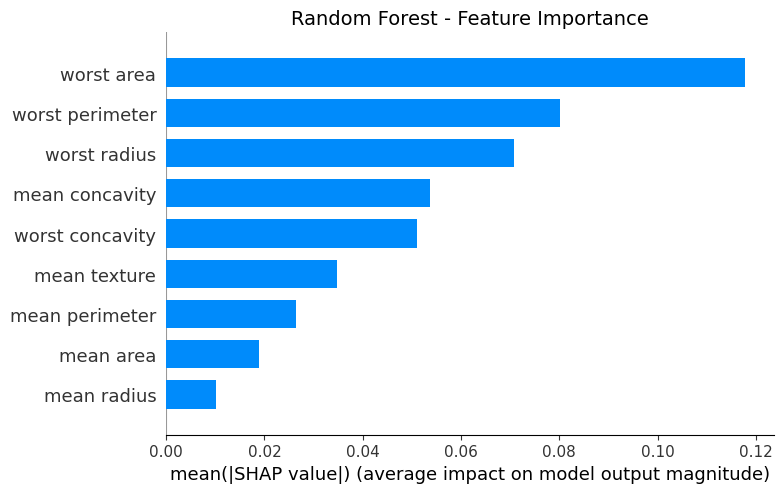

In [ ]:
# RF model
shap.summary_plot(shap_explanation_rf[..., 1], plot_type="bar", show=False)
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()

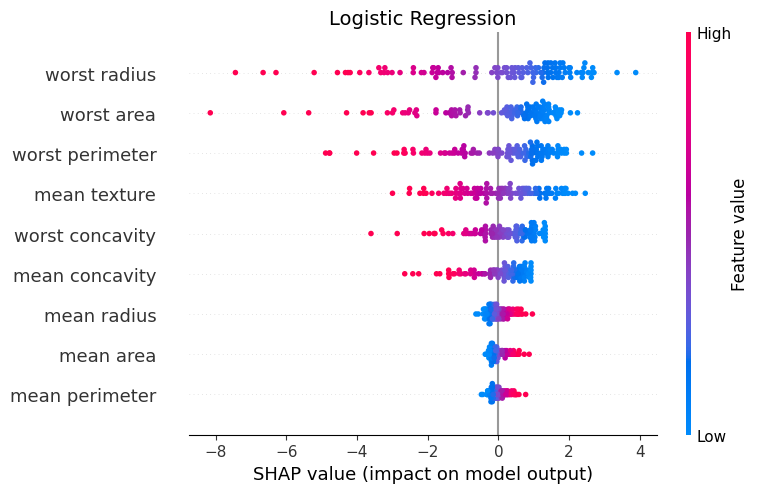

In [ ]:
# Model Behavior Comparison Plots
shap.summary_plot(shap_values_lr, X_test_scaled_df, show=False)
plt.title("Logistic Regression")
plt.tight_layout()
plt.show()

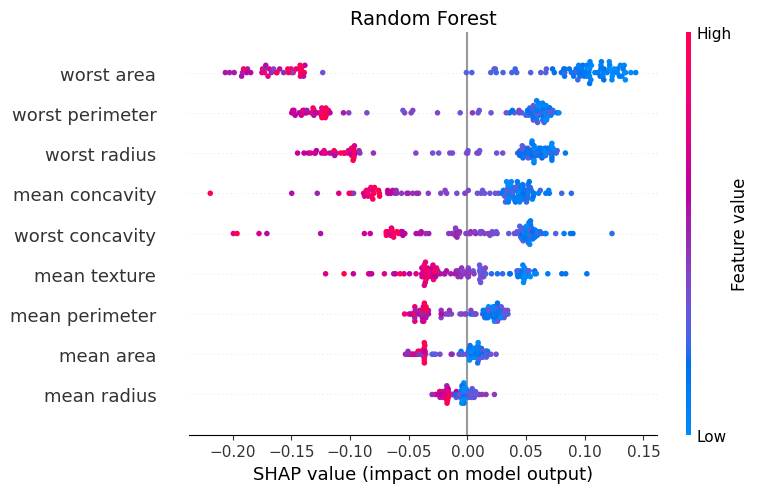

In [ ]:
# RF model
shap.summary_plot(shap_explanation_rf[..., 1], show=False)
plt.title("Random Forest")
plt.tight_layout()
plt.show()

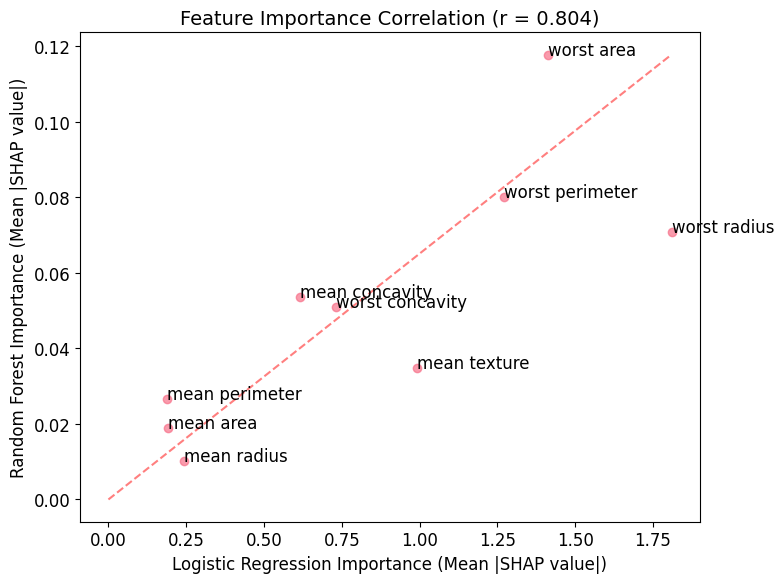

In [ ]:
# Feature Importance Correlation Analysis
lr_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance_lr': np.abs(shap_values_lr).mean(0)
})

rf_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance_rf': np.abs(shap_explanation_rf.values[..., 1]).mean(0)
})

importance_comparison = lr_importance.merge(rf_importance, on='feature')
correlation = np.corrcoef(importance_comparison['importance_lr'],
                          importance_comparison['importance_rf'])[0, 1]

plt.figure(figsize=(8, 6))
plt.scatter(importance_comparison['importance_lr'], importance_comparison['importance_rf'], alpha=0.7)
plt.xlabel('Logistic Regression Importance (Mean |SHAP value|)')
plt.ylabel('Random Forest Importance (Mean |SHAP value|)')
plt.title(f'Feature Importance Correlation (r = {correlation:.3f})')
for i, row in importance_comparison.iterrows():
    plt.annotate(row['feature'], (row['importance_lr'], row['importance_rf']))
plt.plot([0, importance_comparison['importance_lr'].max()],
         [0, importance_comparison['importance_rf'].max()], 'r--', alpha=0.5)
plt.tight_layout()
plt.show()

Explaining prediction for instance with index: 204


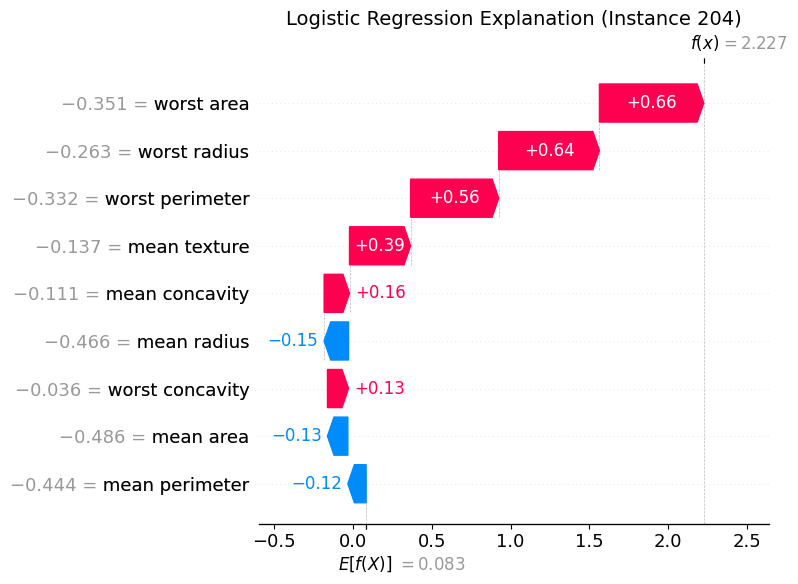

In [ ]:
# Individual Prediction Explanation

# Select a single instance to explain from the test set
instance_index = 0
print(f"Explaining prediction for instance with index: {X_test.index[instance_index]}")

# Create SHAP Explanation object for the specific LR instance
explanation_lr = shap.Explanation(
    values=shap_values_lr[instance_index],
    base_values=explainer_lr.expected_value,
    data=X_test_scaled_df.iloc[instance_index],
    feature_names=X_test.columns.tolist()
)

# Logistic Regression Waterfall Plot
shap.plots.waterfall(explanation_lr, max_display=10, show=False)
plt.title(f"Logistic Regression Explanation (Instance {X_test.index[instance_index]})")
plt.tight_layout()
plt.show()

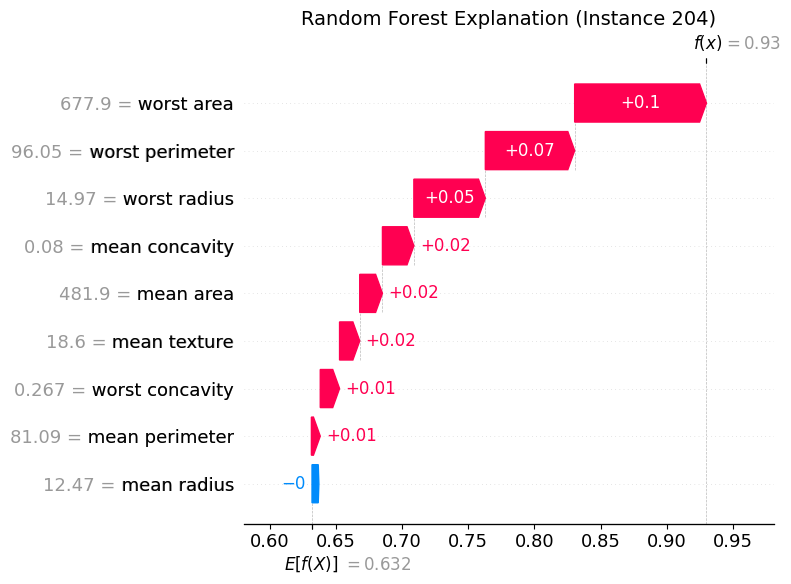

In [ ]:
# For Random Forest
shap.plots.waterfall(shap_explanation_rf[instance_index, :, 1], max_display=10, show=False)
plt.title(f"Random Forest Explanation (Instance {X_test.index[instance_index]})")
plt.tight_layout()
plt.show()